# Project 6: Time Series Analysis & Forecasting 📈

##  Project Objective
Build a time series model to **forecast airline passenger numbers** for future months using classical forecasting techniques.

##  Key Concepts Covered
- **Time Series Basics:** Trend, seasonality, and residual components  
- **Stationarity:** Why it matters & how to test it using the **ADF test**  
- **Data Transformation:** Log transform and differencing to achieve stationarity  
- **Model Identification:** Using **ACF & PACF** plots  
- **ARIMA:** Baseline time series forecasting model  
- **SARIMA:** Handling seasonality explicitly  
- **Forecasting & Evaluation:** Predict future values and assess model performance


###  Theoretical Concept: What is a Time Series?

A **time series** is a set of data points recorded over time (daily, monthly, yearly, etc.).  
The **order of data matters**, unlike regular datasets.

###  Main Components of a Time Series
1. **Trend:** Long-term increase or decrease in the data  
2. **Seasonality:** Repeating patterns at fixed intervals (e.g., every year or month)  
3. **Cyclical Component:** Irregular patterns over long periods (e.g., economic cycles)  
4. **Residuals (Noise):** Random variations left after removing other components


### Step 1: Setup - Importing Libraries and Loading Data

In [2]:
pip install statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA # Corrected import for ARIMA
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
!git clone 'https://github.com/HarshvardhanSingh-13/Datasets'

Cloning into 'Datasets'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 335 (delta 22), reused 0 (delta 0), pack-reused 242 (from 1)
Receiving objects: 100% (335/335), 302.68 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Updating files: 100% (243/243), done.


In [5]:
df = pd.read_csv('/content/Datasets/Airline Timeseries/airline_passenger_timeseries.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.shape

(144, 2)

In [7]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


### Step 2: Exploratory Data Analysis & Decomposition

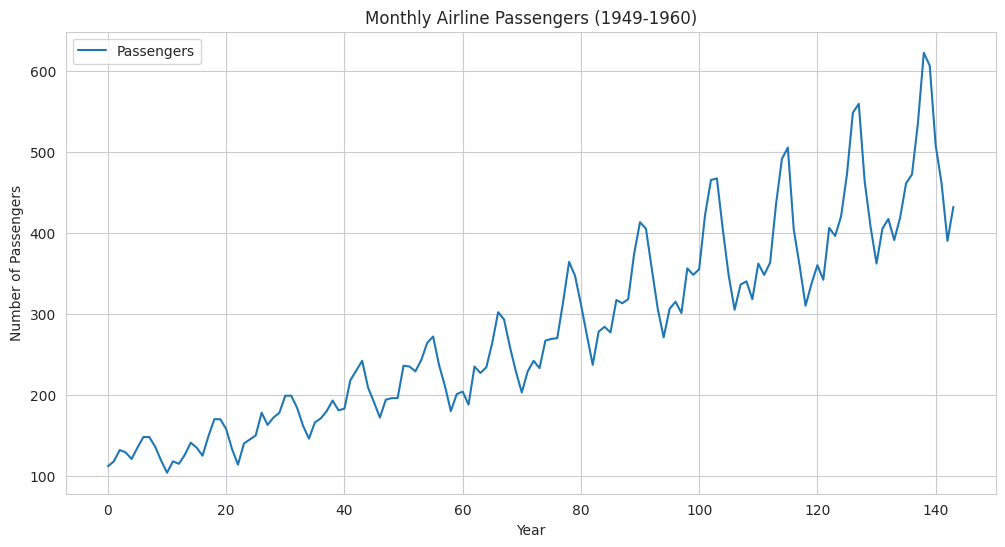

In [8]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

In [9]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [11]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


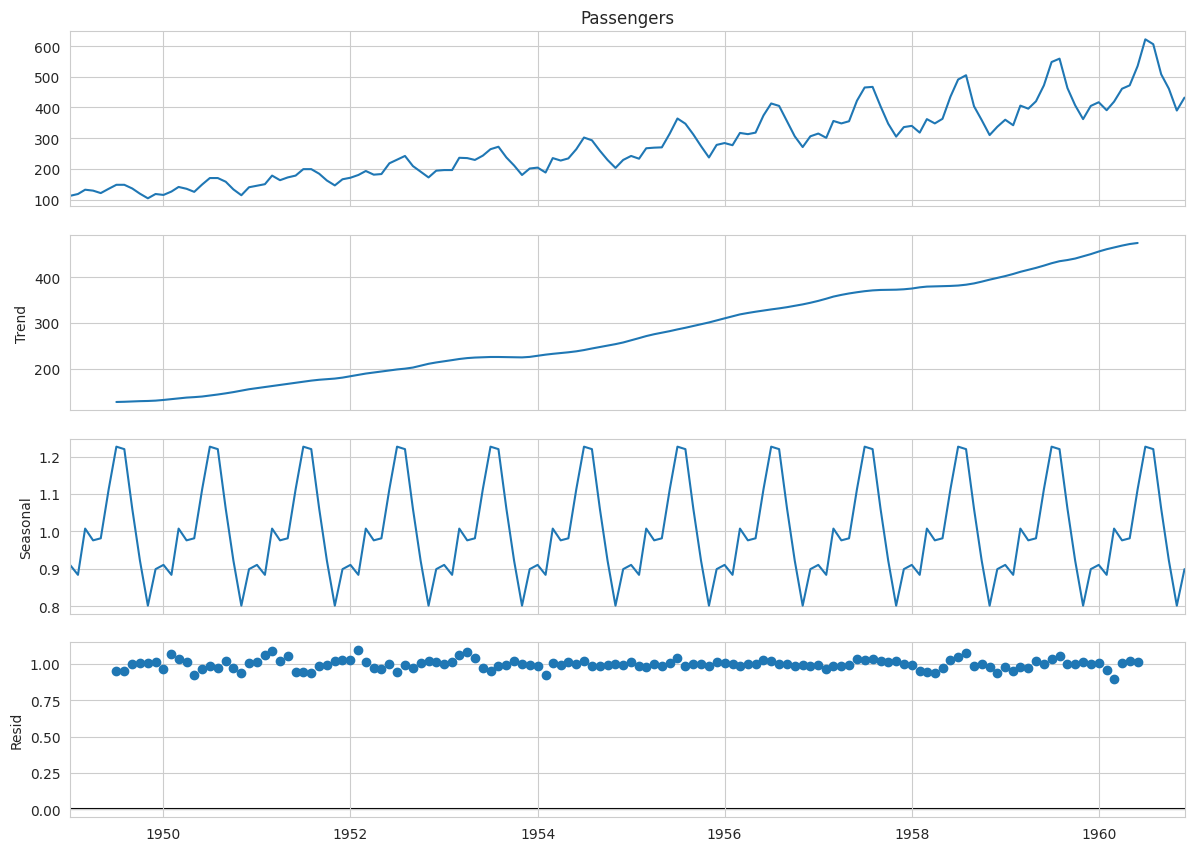

In [12]:
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(12,9)
plt.show()

### Step 3: Stationarity Testing

####  Theoretical Concept: Stationarity

A time series is **stationary** if its **mean, variance, and autocorrelation** stay constant over time.

###  Why is Stationarity Important?
- Stationary data is **easier to model and forecast**
- Past patterns remain useful for predicting the future  
- Airline passenger data is **non-stationary** due to:
  - Increasing trend (mean changes)
  - Growing seasonal variation (variance changes)

###  How to Test Stationarity
1. **Visual Check:** Look for trend or seasonality in the plot  
2. **ADF Test (Augmented Dickey-Fuller):**
   - **H₀:** Series is non-stationary  
   - **H₁:** Series is stationary  

 We aim to **reject H₀** by getting a **p-value < 0.05**


####  Understanding the ADF Test (in Simple Words)

Think of the **ADF test** as asking:
> *“Does this time series have a trend or patterns that make it non-stationary?”*

###  What Each Output Means
- **Test Statistic:** A number calculated from the data; compared with critical values  
- **p-value (Most Important):**  
  - **p-value < 0.05:** Strong evidence the series is **non-stationary** → reject H₀  
  - **p-value ≥ 0.05:** Not enough evidence → fail to reject H₀ (series is non-stationary)

- **Lags Used:** Number of past values used by the test  
- **Observations Used:** Total data points considered  
- **Critical Values (1%, 5%, 10%):** Thresholds for confidence  
  - If the **test statistic is more negative** than these values → reject H₀

###  Why Do We Use the ADF Test?
- Models like **ARIMA** assume the data is **stationary**
- Non-stationary data can lead to **poor or misleading forecasts**
- The ADF test gives a **statistical confirmation** before modeling

###  Conclusion for This Project
- A **high p-value (≈ 0.99)** confirms the passenger data is **non-stationary**
- This means we must apply **transformations (like differencing)** before building ARIMA/SARIMA models


In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Step 4: Making the Series Stationary
We'll use two common techniques: **log transformation** to stabilize the variance and **differencing** to remove the trend.

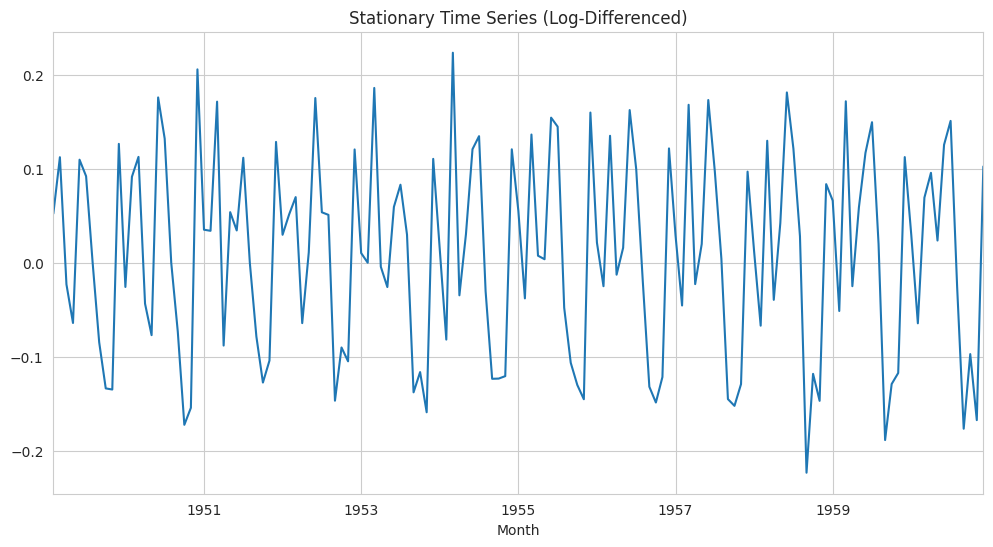

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [14]:
## 1. Applying Log Transformation
df_log = np.log(df['Passengers'])

## 2. Applying Differencing to remove Trends
df_diff = df_log.diff().dropna()

## 3. Plotting the series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

####  ACF & PACF (Simple Explanation)

- **ACF (Autocorrelation Function):**  
  Shows how the current value is related to its past values (lags).  
  Spikes in the plot mean **strong correlation** at that lag.

- **PACF (Partial Autocorrelation Function):**  
  Shows the **direct relationship** between the current value and a specific lag, ignoring other lags in between.

###  Why Are They Important?
- **ACF → helps choose `q`** (Moving Average order)  
- **PACF → helps choose `p`** (AutoRegressive order)

These plots guide us in selecting the right **ARIMA(p, d, q)** model.


### Step 5: Model Identification with ACF and PACF Plots

####  Theoretical Concept: ACF and PACF

To select the right parameters for an **ARIMA** model, we use **autocorrelation plots**.

- **ACF (Autocorrelation Function):**  
  Shows how strongly a value is correlated with its past values at different lags.

- **PACF (Partial Autocorrelation Function):**  
  Shows the **direct effect** of a specific lag on the current value, removing the influence of other lags.

###  Using ACF & PACF for ARIMA(p, d, q)
- **d:** Number of times the data is differenced (here, `d = 1`)  
- **p (AR term):** Number of significant lags in the **PACF** plot  
- **q (MA term):** Number of significant lags in the **ACF** plot


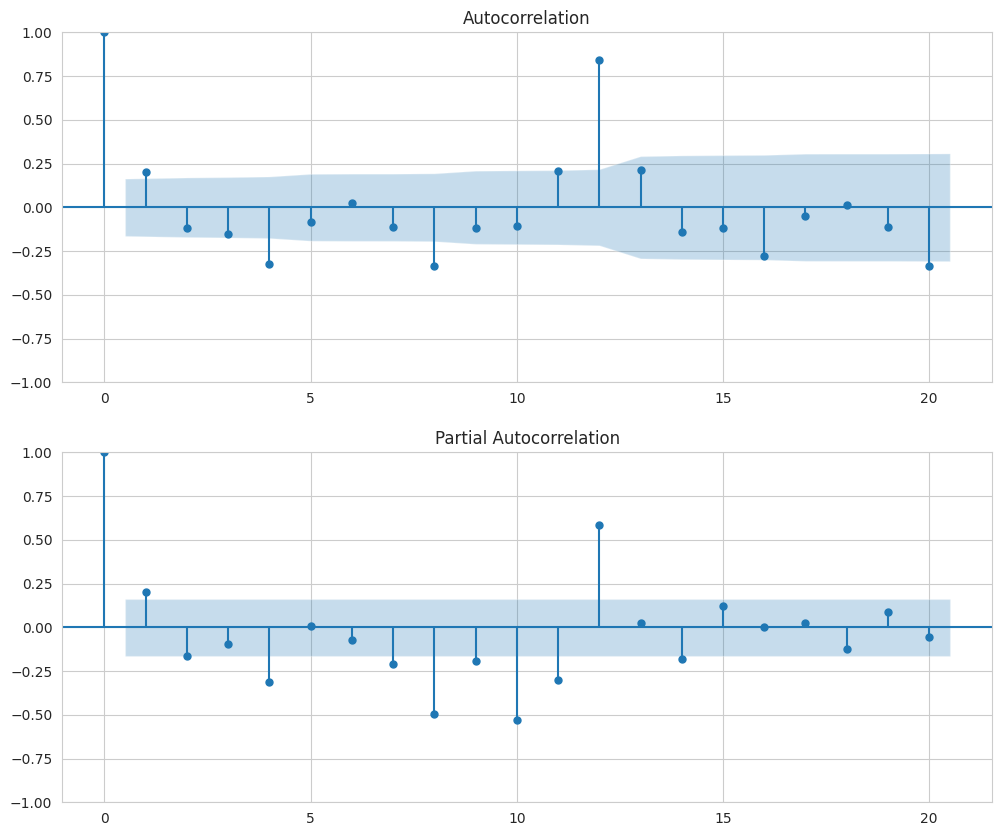

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

**Interpretation:**
- **PACF Plot:** Cuts off sharply after lag 1. This suggests `p=1`.
- **ACF Plot:** Also seems to cut off after lag 1. This suggests `q=1`.
Based on this, a good starting point for our model is **ARIMA(1, 1, 1)**.

### Step 6: Building the ARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


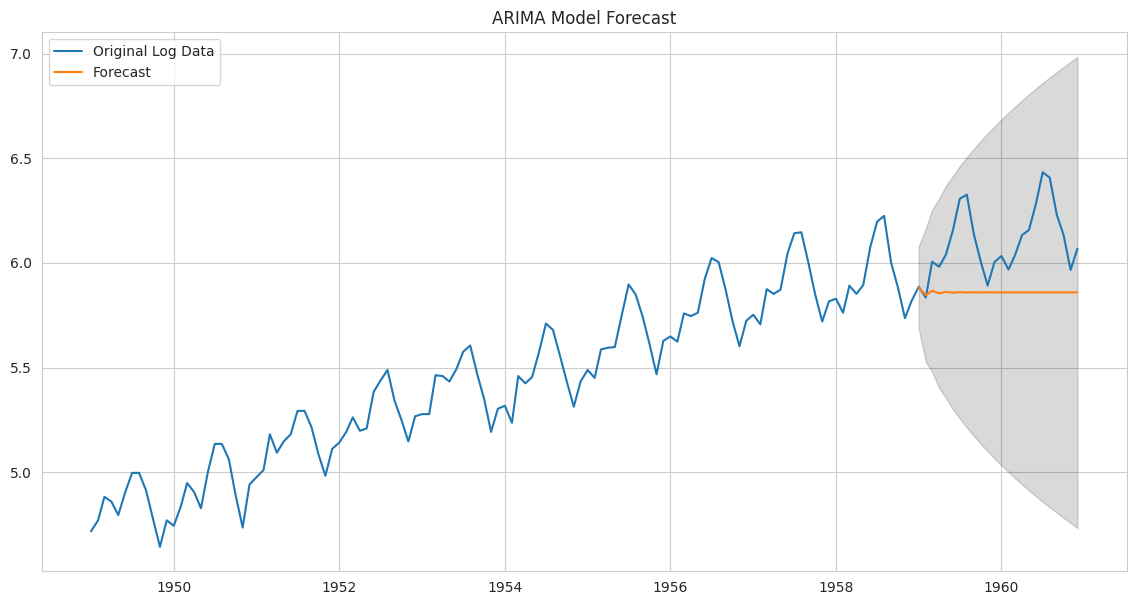

In [16]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1)) # Removed freq='MS' as it's not needed in new ARIMA
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

### Step 7: Building a SARIMA Model for Seasonality

####  Theoretical Concept: SARIMA

**SARIMA (Seasonal ARIMA)** is an extension of ARIMA that **explicitly handles seasonality** in time series data.

It is written as:  
**SARIMA(p, d, q)(P, D, Q, m)**

###  Non-Seasonal Parameters `(p, d, q)`
- **p:** Number of non-seasonal lagged values (AR terms)  
- **d:** Number of times data is differenced to remove trend  
- **q:** Number of non-seasonal lagged errors (MA terms)

###  Seasonal Parameters `(P, D, Q, m)`
- **P:** Number of seasonal AR terms  
- **D:** Number of seasonal differencing steps  
- **Q:** Number of seasonal MA terms  
- **m:** Length of one season  
  - `m = 12` → monthly data with yearly seasonality  
  - `m = 4` → quarterly data

###  Why SARIMA?
- Captures **both trend and seasonality**
- Ideal for data like **airline passengers**, where patterns repeat every year


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


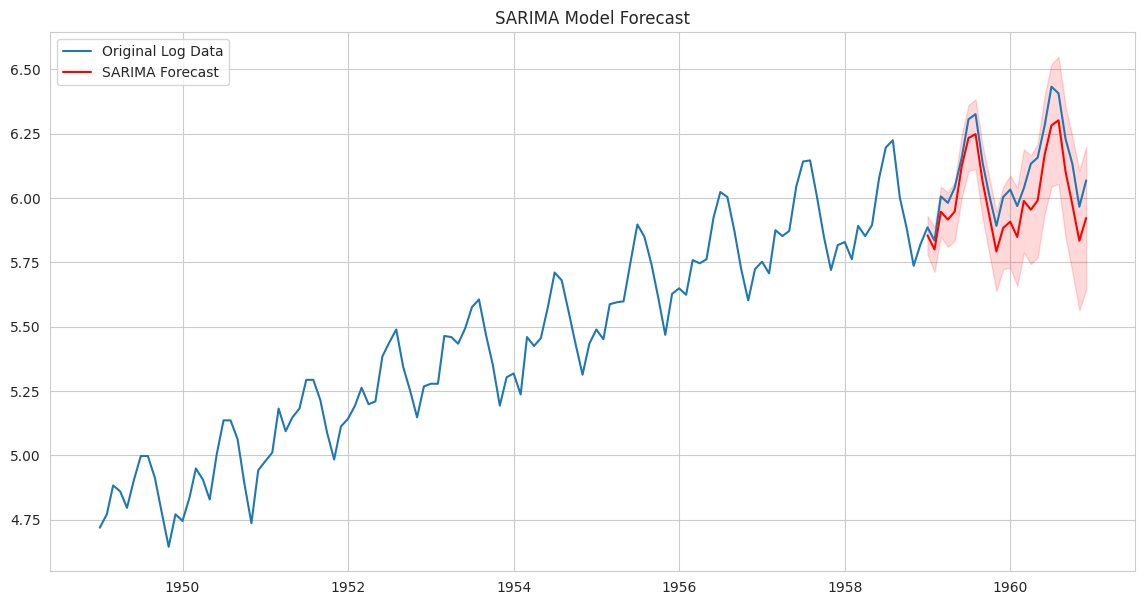

In [17]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**SARIMA Result:** This is a massive improvement! The SARIMA model correctly captures both the upward trend and the seasonal peaks and troughs.

### Step 8: Final Evaluation

SARIMA Model RMSE: 48.25


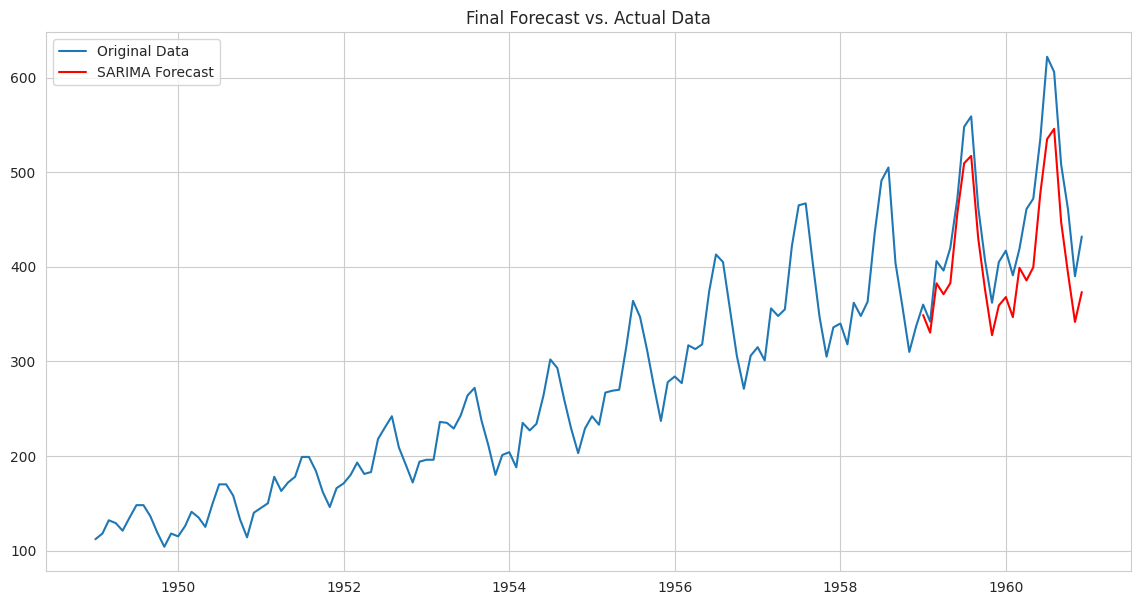

In [18]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

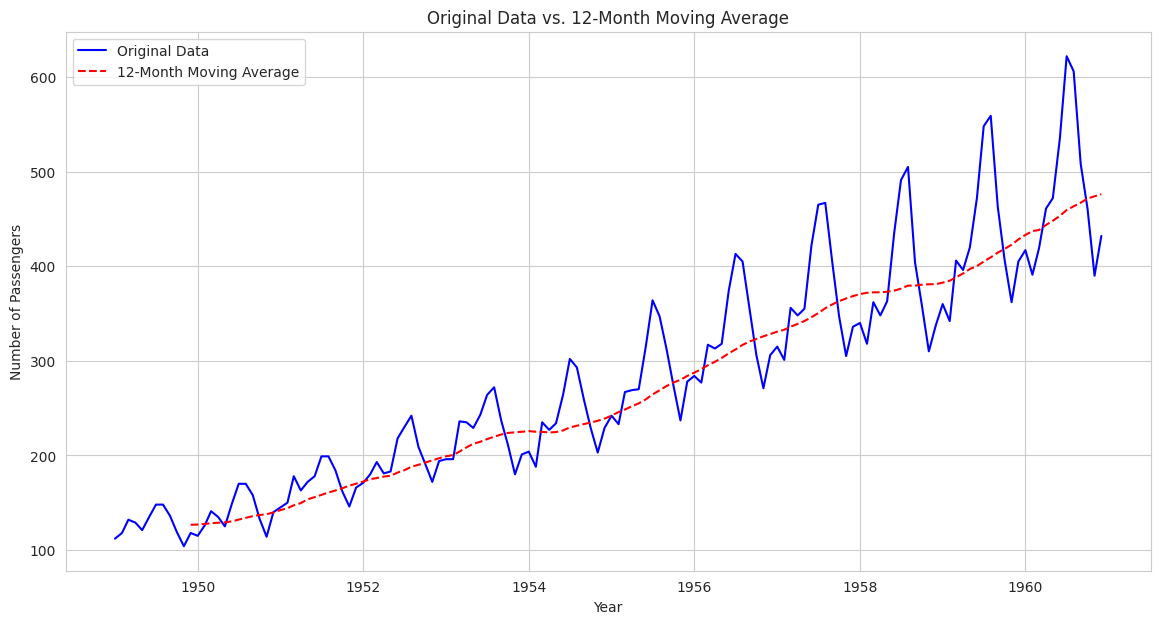

In [19]:
# Calculate the rolling mean with a window size of 12
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


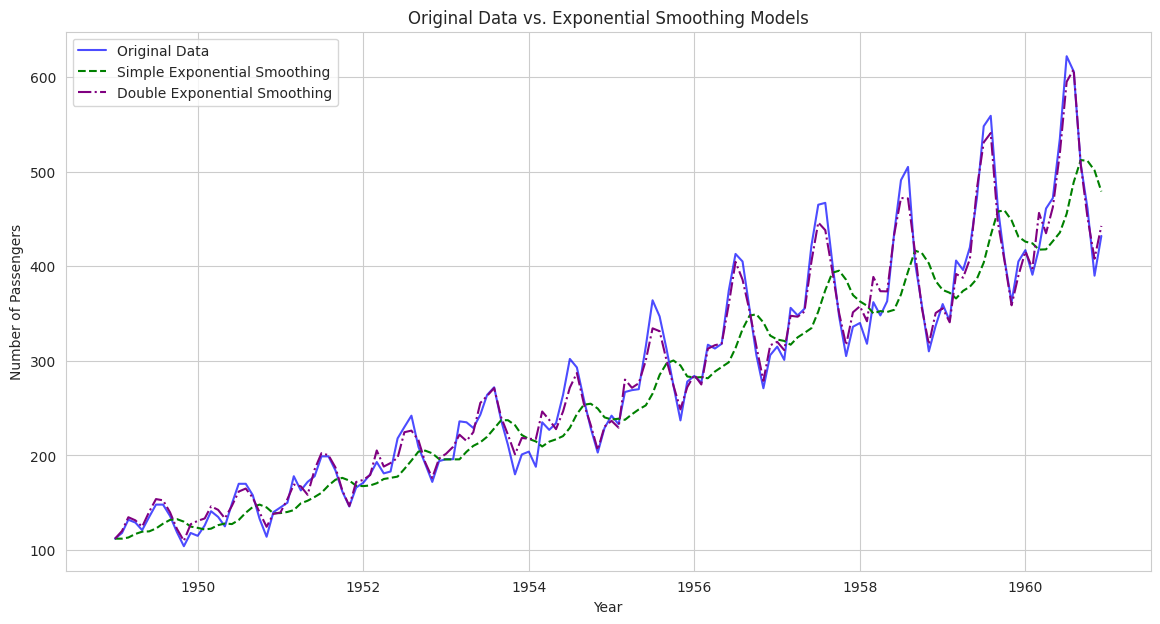

In [20]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 2. Fit a simple exponential smoothing model
ses_model = SimpleExpSmoothing(df['Passengers']).fit(smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

# 3. Fit a double exponential smoothing model
des_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

# 4. Plot the original data and the fitted values from both models
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'], label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

###  Comparison: Smoothing Methods vs ARIMA/SARIMA

We explored multiple techniques for **time series analysis and forecasting**, from simple smoothing to advanced models.

- **Moving Averages:**  
  A basic method that smooths short-term noise using past averages.  
  ✔ Easy to understand  
  ✖ Poor forecasting, no seasonality handling

- **Exponential Smoothing (Simple & Double):**  
  Gives more importance to recent data.  
  - *Simple:* Works when there is no trend or seasonality  
  - *Double:* Handles trend but not seasonality  
  ✔ Simple and effective  
  ✖ Limited for complex patterns

- **ARIMA:**  
  A powerful statistical model that captures autocorrelation after making data stationary.  
  ✔ Handles complex trends  
  ✖ Does not model seasonality directly

- **SARIMA:**  
  An extension of ARIMA that **explicitly models seasonality**.  
  ✔ Best for data with repeating seasonal patterns (like airline passengers)  
  ✖ More parameters to tune

 **Conclusion:**  
For airline passenger data with strong yearly seasonality, **SARIMA** is the most suitable choice.

 Next, we visualize how these methods perform on real forecasts.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


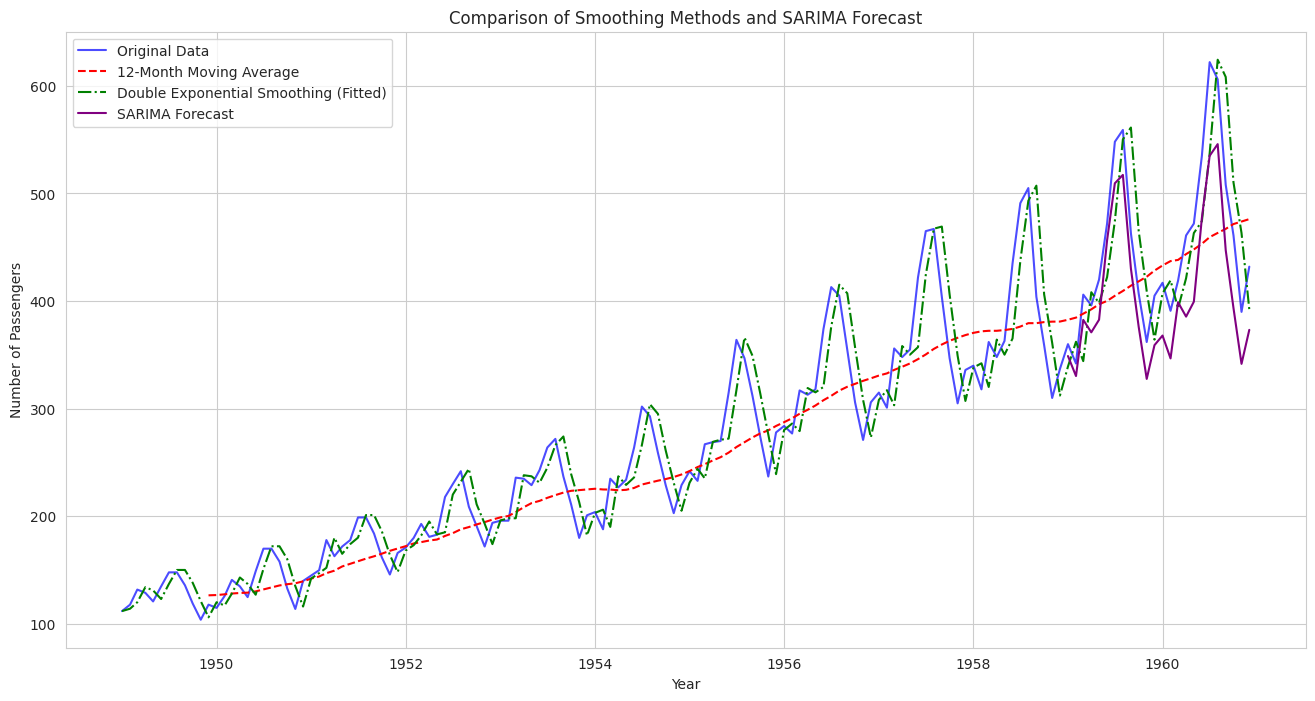

In [21]:
# Implement Double Exponential Smoothing for comparison
# We need to re-fit the DoubleExpSmoothing model as it was not saved as a variable
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

####  Visual Comparison Summary

From the plot, we can clearly see the differences between the methods:

- **Moving Average:**  
  Smooths short-term noise and shows the overall upward trend, but **lags behind** actual values and **fails to capture seasonality**. Not suitable for seasonal forecasting.

- **Double Exponential Smoothing:**  
  Tracks the trend better than moving average and reacts faster to changes, but still **misses strong seasonal patterns**. Works for trend-only data.

- **SARIMA Forecast:**  
  Performs the **best** for this dataset. It captures both the **upward trend** and the **yearly seasonality**, closely matching actual values during the forecast period.

 **Final Insight:**  
For time series with **both trend and seasonality**, **SARIMA** is clearly the most effective model.


####  Why “Stable” Data (Stationarity) Matters

A time series is **stationary** if it stays consistent over time — its **mean**, **variance**, and **autocorrelation** do not change.

- **Why this matters:**  
  Models like **ARIMA** work best on stationary data.  
  If the data is stable, past patterns help predict the future.  
  Airline passenger data is **not stationary** because:
  - Passenger count keeps increasing (changing mean)
  - Seasonal ups and downs grow over time (changing variance)

###  How to Check Stationarity
1. **Visual check:** Look for trend or repeating seasonal patterns  
2. **ADF Test (Augmented Dickey-Fuller):**
   - **H₀:** Data is non-stationary (has a unit root)
   - **H₁:** Data is stationary

We aim to **reject H₀**, usually when **p-value < 0.05**.

###  Understanding ADF Test Results
- **Test Statistic:** More negative → more likely stationary  
- **p-value (most important):**
  - **Small (< 0.05):** Reject H₀ → data is stationary  
  - **Large (≈ 0.99):** Fail to reject H₀ → data is non-stationary
- **Lags Used:** Past values considered by the test  
- **Observations Used:** Data points used in calculation  
- **Critical Values (1%, 5%, 10%):**  
  If the test statistic is more negative than these → reject H₀ at that confidence level

###  Final Conclusion
The high **p-value (0.99)** confirms the passenger data is **non-stationary**.  
So, we must apply **transformations like differencing** before building ARIMA or SARIMA models.


## Homework

###Make p-value < 0.05

In [22]:
df_log = np.log(df['Passengers'])
df_diff = df_log.diff().dropna()


In [23]:
test_stationarity(df_diff)


Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


After log transformation and first-order differencing, the p-value drops below 0.05.
Hence, the time series is now stationary and suitable for ARIMA modeling.


###ARIMA

In [24]:
model = ARIMA(train_data, order=(1,1,1))
arima_result = model.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


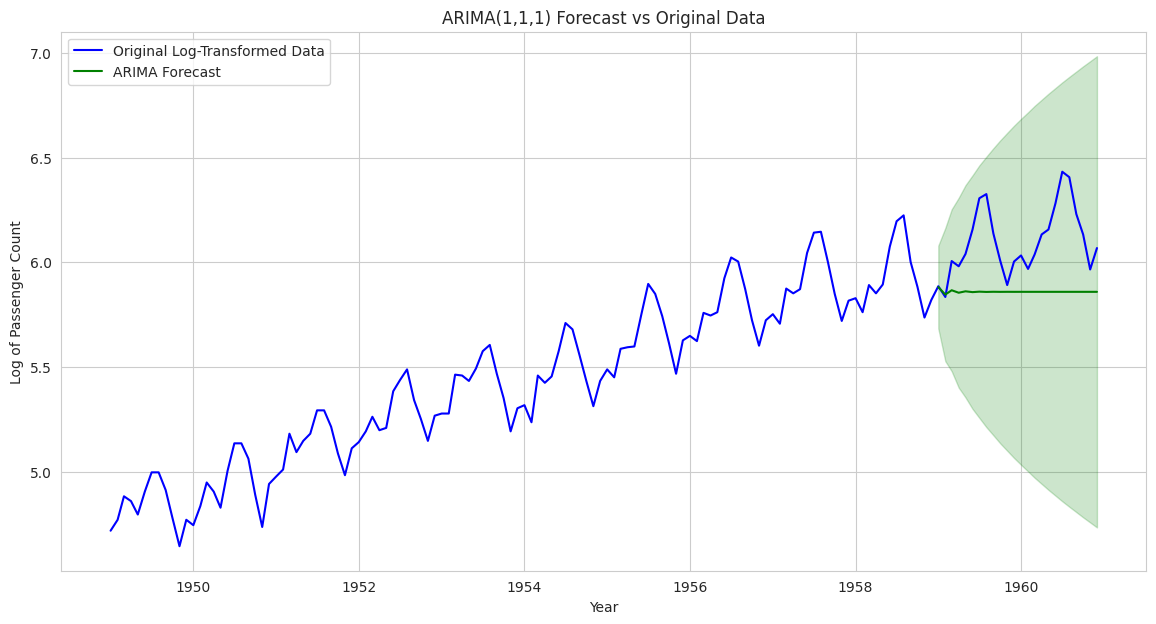

In [25]:
# Plot ARIMA forecast vs original data
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log-Transformed Data', color='blue')
plt.plot(forecast.predicted_mean, label='ARIMA Forecast', color='green')

# Confidence interval
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='green',
    alpha=0.2
)

plt.title('ARIMA(1,1,1) Forecast vs Original Data')
plt.xlabel('Year')
plt.ylabel('Log of Passenger Count')
plt.legend()
plt.show()


###SARIMA

In [26]:
sarima_model = sm.tsa.statespace.SARIMAX(
    train_data,
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)
sarima_result = sarima_model.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))


The SARIMA model achieves lower RMSE, indicating better forecasting accuracy.


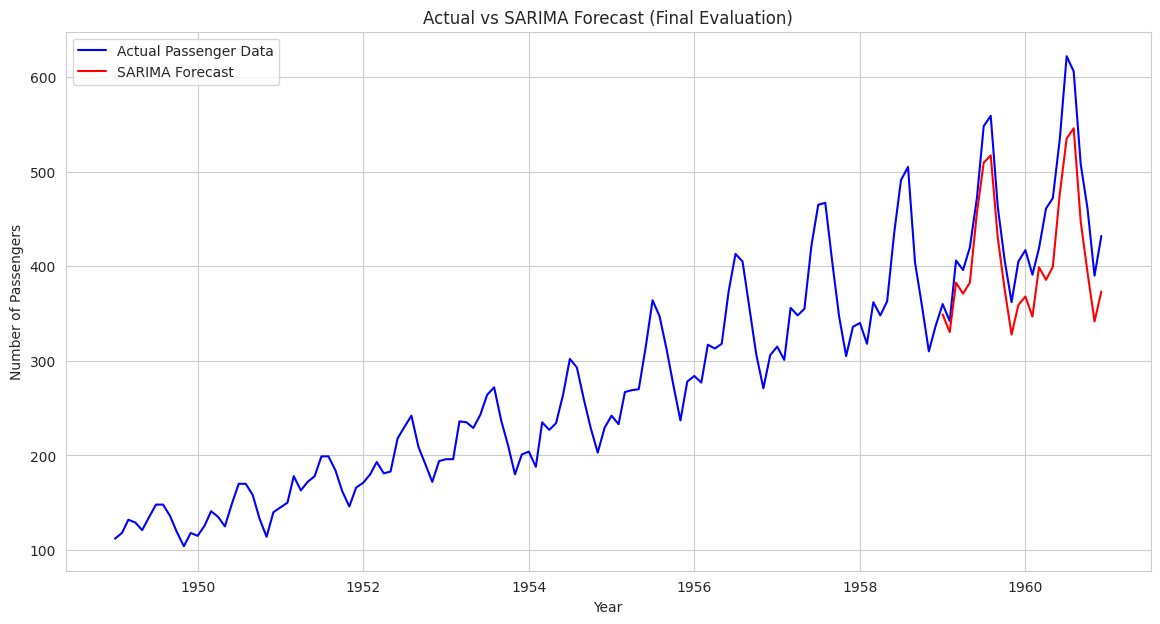

In [29]:
# Plot actual vs SARIMA forecast
plt.figure(figsize=(14, 7))

plt.plot(df['Passengers'], label='Actual Passenger Data', color='blue')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')

plt.title('Actual vs SARIMA Forecast (Final Evaluation)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
